In [2]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

In [3]:
# Funciones propias
from utils_limpieza import * 

In [4]:
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
# Cargar datos
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas = pd.read_csv(path)


C:\Users\Patricio\AppData\Local\Temp\ipykernel_9664\3921706967.py:3: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv(path)


## Hacemos la limpieza sugerida al principio del TP2
- [x] Eliminar las variables en `cols_dropear` (Paso 1).
- [x] Renombrar a 'Otros' las subcategorías que no tengan `MODELO` (Paso 2).

In [6]:
print(f'El df original tiene {ventas.shape[0]} registros y {ventas.shape[1]} variables.\n')

# Paso 1
cols_dropear = ['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 'NOMBRE']
ventas_renamed = limpiar_basic(ventas, cols_drop=cols_dropear)
print(f'Luego del paso 1 quedan se tiran {len(cols_dropear)} variables, quedando {ventas_renamed.shape[1]} variables.\n')

# Paso 2
# ventas_renamed['SUB-CATEGORIA'].nunique() # antes del paso 2
ventas_renamed = renombrar_elementos(ventas_renamed, 
                                     columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

scu_vr = ventas_renamed['SUB-CATEGORIA'].nunique()
scu_ot = ventas_renamed['SUB-CATEGORIA'].nunique() - scu_vr + 1
print(f'Luego del paso 2 quedan {scu_vr} subcategorías únicas.')
print(f'Las {scu_ot} subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".')
print(f'Las {scu_vr-1} subcategorías que sí tienen vendedores modelo son:')

ventas_renamed.groupby(by=['SUB-CATEGORIA'])['MODELO'].sum().sort_values(ascending=False)[:12]

El df original tiene 435489 registros y 19 variables.

Luego del paso 1 quedan se tiran 5 variables, quedando 14 variables.

Luego del paso 2 quedan 13 subcategorías únicas.
Las 1 subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".
Las 12 subcategorías que sí tienen vendedores modelo son:


SUB-CATEGORIA
Venta de Artículos, productos, accesorios, etc de diversos materiales      1902
Venta de Combustibles (Incluye tmb gas, carbón, leña, etc)                  951
Venta de Productos Alimenticios, Bebidas, Lácteos y afines                  586
Venta de Productos farmacéuticos, de perfumería, cosméticos y similares     420
Venta de Combustibles Ley 23966 (Incluye tmb gas, carbón, leña, etc)        394
Venta en Comisión, Consignación o Intermediación de Productos Varios        336
Cigarrillos, tabacos y afines                                               282
Supermercados, Hipermercados, Kioscos y afines                              156
Venta de Combustibles para reventa (Incluye tmb gas, carbón, leña, etc)     131
Venta de Autos, Camionetas, Motos, y Afines                                 126
Venta de Semillas, Fertilizantes, Granos y afines                            84
Instalación, Mantenimiento, Reparación, etc de productos varios               6
Name: MODELO, dtype: int64

## Análisis de datos faltantes
- [x] Chequear presencia de datos faltantes
- [x] Analizar su correlación
- [x] Imputar de valores faltantes: `CM` y `Trat_Dif` con 'No'.

Faltan datos en las mismas variables que antes. Imputo los complementos en `CM` y `Trat_Dif` para dejarlas listas. Luego de eso, se cumple lo que ya habíamos visto en el tp1.

In [7]:
ventas_renamed.columns

Index(['ID_VENDEDOR', 'AÑO', 'MES', 'DEPOSITO', 'TOTAL_VENTAS',
       'PORCENTAJE_COMISION_EMPRESA', 'COMISION_EMPRESA', 'TRATAMIENTO_FISCAL',
       'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL', 'CM04',
       'SUB-CATEGORIA', 'OMEGA', 'MODELO'],
      dtype='object')

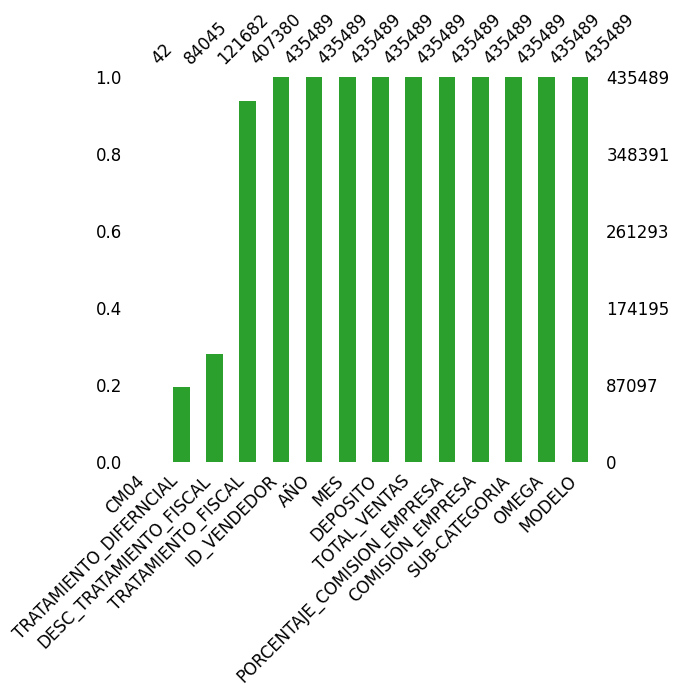

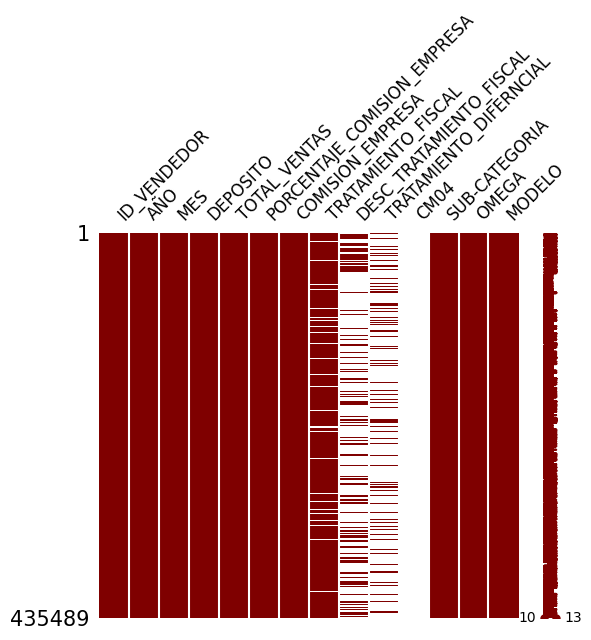

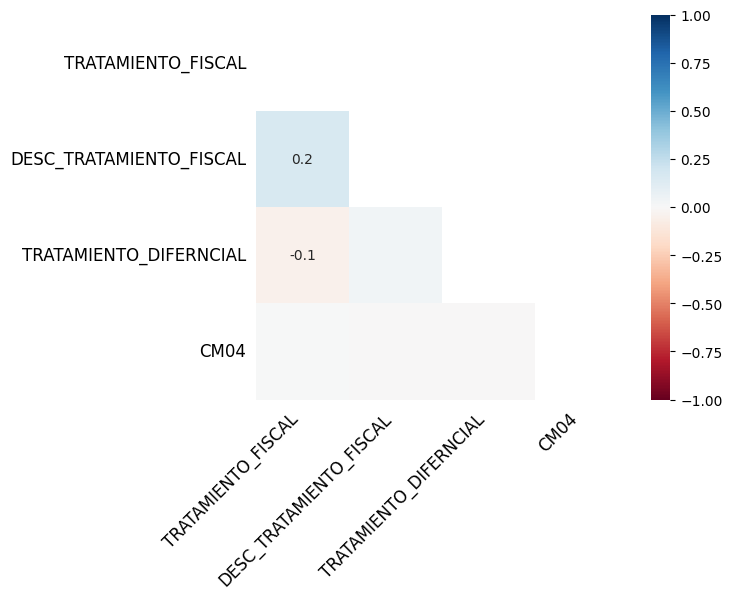

In [8]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

In [9]:
ventas_renamed['CM04'] = ventas_renamed['CM04'].fillna('No')
ventas_renamed['TRATAMIENTO_DIFERNCIAL'] = ventas_renamed['TRATAMIENTO_DIFERNCIAL'].fillna('No')

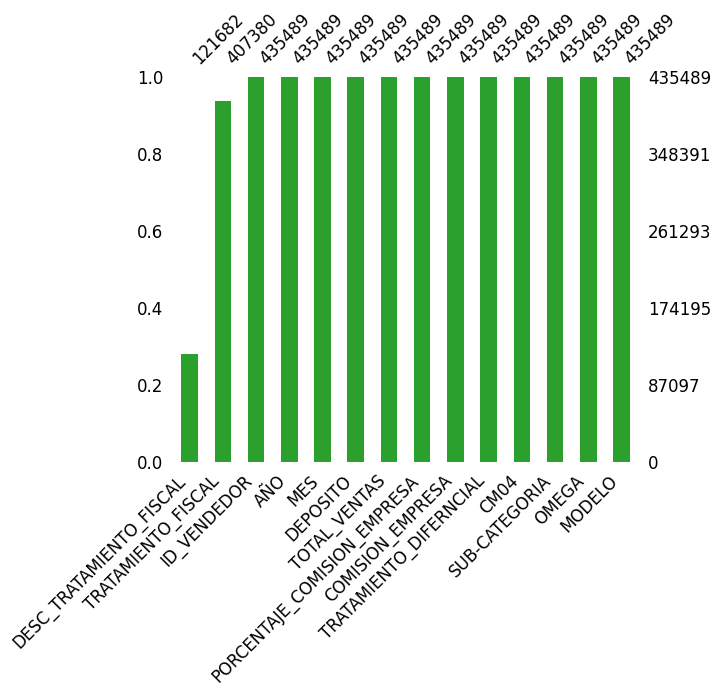

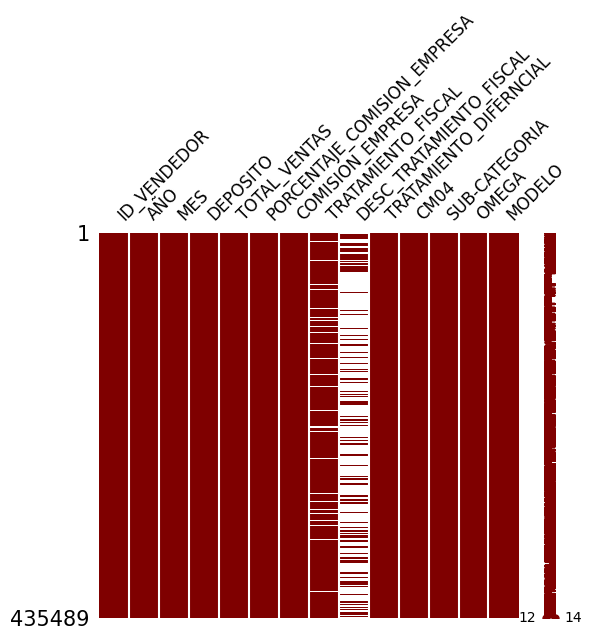

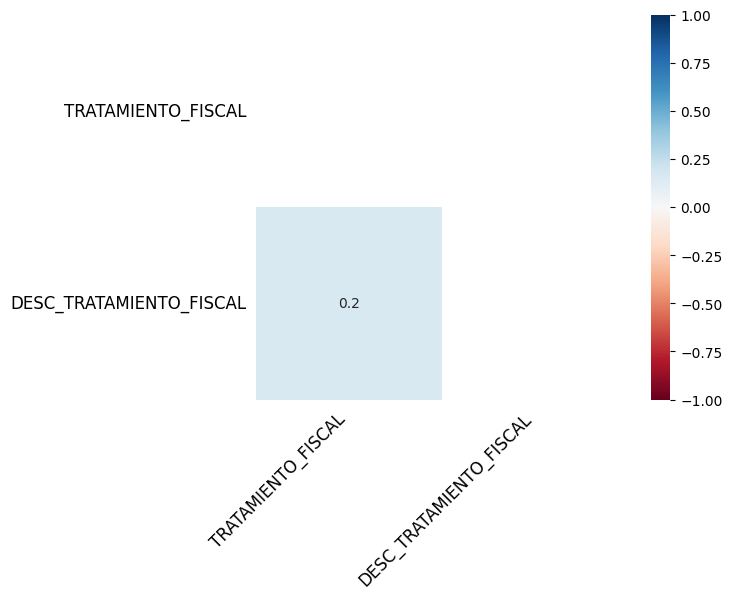

In [10]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

## Anonimizado + simplificación de variables y valores
- [x] Simplificamos el nombre de las variables.
- [x] Anonimizamos la variable sensible `ID` (Paso 3).
- [x] Simplificamos (podría decir acá también que anonimizamos?) valores en `Deposito`
- [x] Unificacón y simplificación de categorías de `Trat_Fisc`.
- [x] Simplificación de categorías de `Trat_Fisc_Agg` y `Trat_Dif`.
- [x] Simplificación de categorías en `Categoria`.
- [x] Guardamos todos estos diccionarios.
- [x] CM: de Si/No a 1/0.

In [11]:
# Se modifican los nombres de las columnas

# Renombramos
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas_renamed.rename(columns = column_dict, inplace = True)
ventas_renamed.columns

Index(['ID', 'Año', 'Mes', 'Deposito', 'Ventas', 'Alicuota', 'Comision',
       'Trat_Fisc', 'Trat_Fisc_Agg', 'Trat_Dif', 'CM', 'Subrubro', 'Omega',
       'Modelo'],
      dtype='object')

In [12]:
# Anonimizamos y guardamos el diccionario para no perder esta info
ventas_hash, dict_id = anonimizar(ventas_renamed, 'ID')

with open("../references/tp2_ID_dict.json", "w") as fp:
    json.dump(dict_id, fp)

print('¡Diccionario generado!')

Actualizando variable ID
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [13]:
# Mapeo de `Deposito` a enteros
ventas_hash, dict_dep = anonimizar(ventas_hash, 'Deposito')

with open("../references/tp2_deposito_dict.json", "w") as fp:
    json.dump(dict_dep, fp)

print('¡Diccionario generado!')

Actualizando variable Deposito
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [14]:
# Mapeo de `CM` según "Si" >> 1 y "No" >> 0.
ventas_hash['CM'] = ventas_hash['CM'].replace({'No': 0, 'Si': 1})

In [15]:
# Unificacón y simplificación de categorías de `Trat_Fisc`
with open("../references/tp1_trat_fisc_dict.json") as trat_fisc_dict_json:
    trat_fisc_dict = json.load(trat_fisc_dict_json)
    
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].astype(str)
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].replace(trat_fisc_dict)

In [16]:
# Simplificación de categorías de `Trat_Fisc_Agg`
with open("../references/tp1_trat_fisc_agg_dict.json") as trat_fisc_agg_dict_json:
    trat_fisc_agg_dict = json.load(trat_fisc_agg_dict_json)

ventas_hash['Trat_Fisc_Agg'] = ventas_hash['Trat_Fisc_Agg'].replace(trat_fisc_agg_dict)

In [17]:
# Simplificación de categorías de `Trat_Dif`
with open("../references/tp1_trat_diff_dict.json") as trat_dif_dict_json:
    trat_dif_dict = json.load(trat_dif_dict_json)

ventas_hash['Trat_Dif'] = ventas_hash['Trat_Dif'].replace(trat_dif_dict)

In [18]:
# Simplificación de categorías de `Subrubro`
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas_hash['Subrubro'] = ventas_hash['Subrubro'].replace(subrubro_dict)

In [19]:
ventas_hash['Subrubro'].unique()

array(['Miscelaneo', 'Otros', 'Venta Agrop.', 'Gondola', 'Supermercados',
       'Comb.', 'Farmacia', 'Mantenimiento', 'Com. Varios', 'Vehiculos',
       'Comb. Ley', 'Tabaco', 'Comb. Reventa'], dtype=object)

In [20]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_hash.to_csv('../data/interim/tp2_ventas_hash.csv', index=False)

## Variable fecha (Paso 6).
Consideramos que para el análisis temporal habrá momentos en que necesitamos tener Año y Mes por separado, pero en otras ocasiones necesitamos toda la información al mismo tiempo. Por lo tanto, creamos la variable FECHA:
    $$FECHA = Año + Mes$$

In [21]:
ventas_hash["FECHA"] = pd.to_datetime(ventas_hash['Mes'].astype(str) + '-' + ventas_hash['Año'].astype(str), format='%m-%Y')
ventas_hash[:3]

,ID,Año,Mes,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA
0,0,2019,1,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
1,1,2019,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
2,1,2019,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01


## Eliminación efecto inflación
Las variables expresadas en pesos aumentan mes a mes por efecto de la inflación. Lo que impide comparar un valor monetario de un mes contra el del mes siguiente. A fin de eliminar este efecto, una alternativa es reexpresar los valores monetarios respecto a un mes base. Por ejemplo, el último mes de la serie.

In [22]:
ventas_ipc = ventas_hash.copy()

In [23]:
# Obtener el último mes
año = ventas_ipc['Año'].max()
mes = ventas_ipc[ventas_ipc['Año'] == ventas_ipc['Año'].max()]['Mes'].max()
print(f"El último mes de la serie es el {mes} de {año}")

El último mes de la serie es el 6 de 2022


El procedimiento es el siguiente:
    $$\text{VAR}_{mm-aaaa} \frac{\text{IPC}_{06-2022}}{\text{IPC}_{mm-aaaa}}$$

Para todo valor de cada variable (VAR) correspondiente a cierto mes "mm-aaaa" se lo divide por el Índice de Precios al Consumidor (IPC) correspondiente a ese mes "mm-aaaa" y luego se lo multiplica por el IPC correspondiente al mes "06-2022".

De esta forma, todos los valores de cada variable VAR van a quedar expresados en unidades monetarias del "06-2022".



Es necesario obtener de manera externa una serie del IPC que publica Indec.

In [24]:
precios = "../data/external/IPC_Indec.csv"

if exists(precios):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["FECHA", "INDICE"]
    df["FECHA"] = pd.to_datetime(df["FECHA"])
    df.to_csv(precios, index=False)

Este archivo ya existe.


In [25]:
# Abrir dataset de precios
precios = pd.read_csv(precios)
precios.head()

,FECHA,INDICE
0,2016-12-01,100.0000
1,2017-01-01,101.5859
2,2017-02-01,103.6859
3,2017-03-01,106.1476
4,2017-04-01,108.9667


Luego debemos unir ambas bases de datos (ventas y precios), de acuerdo a la variable clave `FECHA`

In [26]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

datetime64[ns]
object


In [27]:
# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["FECHA"] = pd.to_datetime(precios["FECHA"])

In [28]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

datetime64[ns]
datetime64[ns]


In [29]:
ventas_ipc = ventas_ipc.merge(precios[["FECHA", "INDICE"]], on="FECHA", how="left")
ventas_ipc.head(3)

,ID,Año,Mes,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA,INDICE
0,0,2019,1,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,2019,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2019,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101


In [30]:
# Creamos una variable que almacene el valor del índice para el 06 de 2022
indice_06_2022 = ventas_ipc[ventas_ipc["FECHA"] == ventas_ipc["FECHA"].max()]["INDICE"].values[0]

La series que están expresadas en pesos son las siguientes: 
   * `Ventas`
   * `Comision`

In [31]:
ventas_ipc["Ventas_Reales"] = (ventas_ipc["Ventas"]  * indice_06_2022 / ventas_ipc["INDICE"])
ventas_ipc["Comision_Real"] = (ventas_ipc["Comision"]  * indice_06_2022 / ventas_ipc["INDICE"])
ventas_ipc.head(3)

,ID,Año,Mes,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,FECHA,INDICE,Ventas_Reales,Comision_Real
0,0,2019,1,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,6.115592e+04,1712.363645
1,1,2019,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,2.613046e+05,10452.185376
2,1,2019,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,1.411122e+07,564448.625587


In [32]:
ventas_agrupadas = ventas_ipc[['FECHA', 'Ventas', 'Ventas_Reales', 'Comision', 'Comision_Real']].copy()
ventas_agrupadas = ventas_agrupadas.groupby('FECHA').sum()[['Ventas', 'Ventas_Reales', 'Comision', 'Comision_Real']].reset_index()

Veamos gráficamente el efecto de la operación (por simplicidad se grafican mensualmente las series de tiempo agregando los valores por suma):

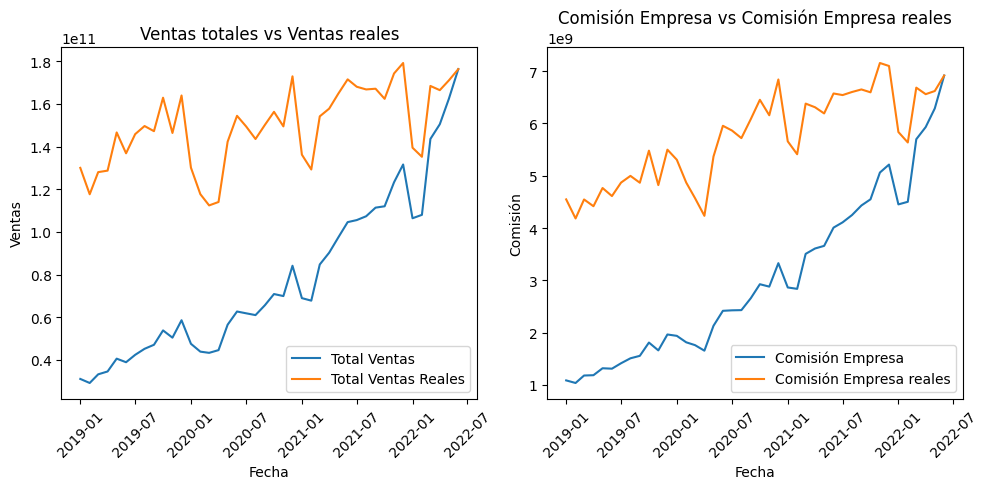

In [33]:
# Crear el layout con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Primer subplot: Ventas totales vs Ventas reales
ax1.plot(ventas_agrupadas['FECHA'], ventas_agrupadas['Ventas'], label='Total Ventas')
ax1.plot(ventas_agrupadas['FECHA'], ventas_agrupadas['Ventas_Reales'], label='Total Ventas Reales')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ventas')
ax1.set_title('Ventas totales vs Ventas reales')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Segundo subplot: Comisión Empresa vs Comisión Empresa Reales
ax2.plot(ventas_agrupadas['FECHA'], ventas_agrupadas['Comision'], label='Comisión Empresa')
ax2.plot(ventas_agrupadas['FECHA'], ventas_agrupadas['Comision_Real'], label='Comisión Empresa reales')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Comisión')
ax2.set_title('Comisión Empresa vs Comisión Empresa reales')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En las variantes llamadas "Reales", se observa una pendiente más moderada. El efecto de la inflación ha sido "descartado". De aquí en adelante, a la hora de hablar de los valores de estas variables, la interpretación correcta será "$ XX.XXX a precios de junio de 2022"

In [34]:
ventas_ipc.columns

Index(['ID', 'Año', 'Mes', 'Deposito', 'Ventas', 'Alicuota', 'Comision',
       'Trat_Fisc', 'Trat_Fisc_Agg', 'Trat_Dif', 'CM', 'Subrubro', 'Omega',
       'Modelo', 'FECHA', 'INDICE', 'Ventas_Reales', 'Comision_Real'],
      dtype='object')

In [35]:
# # Se descartan las variables que no se usan
ventas_ipc = limpiar_basic(ventas_ipc, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas_ipc.rename(columns = {'FECHA': 'Fecha', 
                              'Ventas_Reales': 'Ventas', 
                              'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas_ipc = ventas_ipc[['ID', 'Omega', 'Subrubro', 'Trat_Fisc_Agg', 
                          'Trat_Fisc', 'Trat_Dif', 'CM', 'Año', 'Mes', 
                          'Fecha','Deposito', 'Ventas', 
                          'Alicuota', 'Comision', 'Modelo']]

ventas_ipc = ventas_ipc.sort_values(['Año', 'Mes', 'Ventas']).reset_index(drop=True)

In [36]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv', index=False)

## Análisis de variables categóricas

### Relación entre `Trat_Fisc` y `Trat_Fisc_Agg`.
### Relación entre `Trat_Fisc` y `Trat_Dif`
### `Trat_Fisc` vs `Trat_Fisc_Agg`

In [37]:
ventas_ipc.head(3)

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Año,Mes,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,1657,1,Venta Agrop.,NaN,Norm,No,0,2019,1,2019-01-01,9,-1.116697e+07,2.00,-223339.447058,0
1,1278,1,Venta Agrop.,NaN,nan,No,0,2019,1,2019-01-01,9,-5.494877e+06,2.40,-131877.053284,0
2,1358,1,Otros,NaN,nan,No,0,2019,1,2019-01-01,188,-2.706374e+06,2.75,-74425.291459,0


In [38]:
vendedores = ventas_ipc.drop(['Año', 'Mes', 'Fecha', 'Ventas', 'Alicuota', 'Comision'], axis=1).copy()
vendedores.head(3)

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Deposito,Modelo
0,1657,1,Venta Agrop.,NaN,Norm,No,0,9,0
1,1278,1,Venta Agrop.,NaN,nan,No,0,9,0
2,1358,1,Otros,NaN,nan,No,0,188,0


In [39]:
for columna in vendedores.columns:
    recuento_valores = vendedores[columna].value_counts()
    print(f"Recuento de valores para la variable '{columna}':")
    print(recuento_valores)
    print()

Recuento de valores para la variable 'ID':
ID
1177    1667
1082    1428
1153    1291
1309    1285
1161    1263
        ... 
1073       1
347        1
3201       1
3191       1
3234       1
Name: count, Length: 3235, dtype: int64

Recuento de valores para la variable 'Omega':
Omega
1    432897
0      2592
Name: count, dtype: int64

Recuento de valores para la variable 'Subrubro':
Subrubro
Miscelaneo       141784
Otros             56781
Gondola           56215
Com. Varios       46722
Vehiculos         23647
Venta Agrop.      23327
Comb.             22607
Farmacia          18382
Comb. Ley         16626
Supermercados     10598
Mantenimiento      8086
Comb. Reventa      5657
Tabaco             5057
Name: count, dtype: int64

Recuento de valores para la variable 'Trat_Fisc_Agg':
Trat_Fisc_Agg
Norm      114621
Otro        6233
Exento       826
Min            2
Name: count, dtype: int64

Recuento de valores para la variable 'Trat_Fisc':
Trat_Fisc
Norm                 183611
0                  

### `ID` y `Modelo`

In [85]:
# Verificar si existen diferentes valores de Modelo para un mismo ID
conteo_modelo = vendedores.groupby('ID')['Modelo'].nunique().copy()

# Filtrar los IDs con diferentes valores de Modelo
ids_con_diferentes_modelos = conteo_modelo[conteo_modelo > 1]

if ids_con_diferentes_modelos.empty:
    print("Para cada ID solo existe un valor de Modelo.")
else:
    print("Para algunos IDs se asignan diferentes valores de Modelo:")
    print(ids_con_diferentes_modelos.sort_values(ascending=False))

Para cada ID solo existe un valor de Modelo.


Esto implica, que si hay un vendedor que vende en más de un rubro, tiene la etiqueta de Modelo en todos los rubros.

### `Omega` y `Modelo`

En primer lugar, verificar si a cada ID único se le asigna un único valor de Omega (no debería pasar)

In [84]:
# Verificar si existen diferentes valores de Omega para un mismo ID
conteo_omega = vendedores.groupby('ID')['Omega'].nunique().copy()

# Filtrar los IDs con diferentes valores de Omega
ids_con_diferentes_omegas = conteo_omega[conteo_omega > 1]

if ids_con_diferentes_omegas.empty:
    print("Para cada ID solo existe un valor de omega.")
else:
    print("Para algunos IDs se asignan diferentes valores de omega:")
    print(ids_con_diferentes_modelos.sort_values(ascending=False))

Para cada ID solo existe un valor de omega.


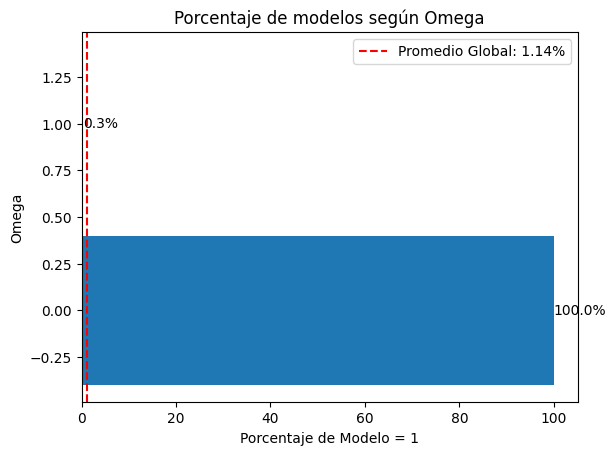

In [108]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].drop_duplicates(subset=['ID']).copy()
vendedores_1 = vendedores.drop_duplicates(subset='ID').copy()

porcentaje_modelo_1 = modelo_1.groupby('Omega')['Modelo'].count() / vendedores_1.groupby('Omega')['Modelo'].count() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('Omega')
plt.title('Porcentaje de modelos según Omega')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()

### `Subrubro` y `Modelo`

In [83]:
# Verificar si existen diferentes valores de Subrubro para un mismo ID
conteo_subrubro = vendedores.groupby('ID')['Subrubro'].nunique().copy()

# Filtrar los IDs con diferentes valores de Subrubro
ids_con_diferentes_subrubros = conteo_subrubro[conteo_subrubro > 1]

if ids_con_diferentes_subrubros.empty:
    print("Para cada ID solo existe un valor de subrubro.")
else:
    print("Para algunos IDs se asignan diferentes valores de subrubro:")
    print(ids_con_diferentes_subrubros.sort_values(ascending=False))

Para algunos IDs se asignan diferentes valores de subrubro:
ID
1161    11
2116    11
1325    11
1101    10
1178    10
        ..
1473     2
1486     2
1492     2
1505     2
3232     2
Name: Subrubro, Length: 1691, dtype: int64


En secciones previas se probó que si un ID era Modelo en un rubro, también lo era en todos.

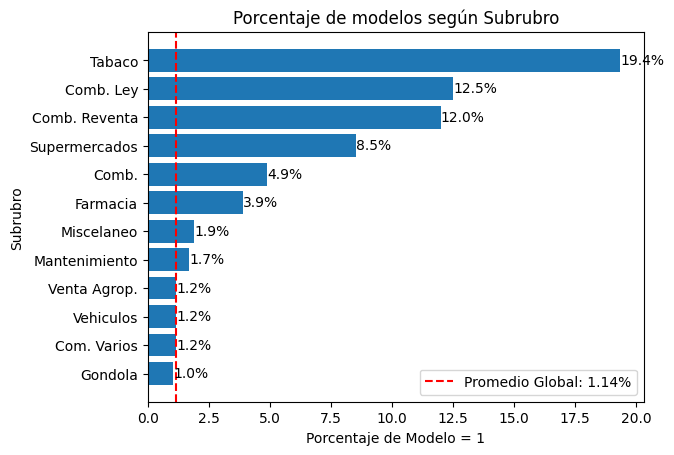

In [100]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].drop_duplicates(subset=['ID','Subrubro']).copy()
vendedores_1 = vendedores.drop_duplicates(subset='ID').copy()

porcentaje_modelo_1 = modelo_1.groupby('Subrubro')['Modelo'].count() / vendedores_1.groupby('Subrubro')['Modelo'].count() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('Subrubro')
plt.title('Porcentaje de modelos según Subrubro')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()

### `Trat_Fisc_Agg` y `Modelo`

De qué depende el tratamiento fiscal? del cliente? Del vendedor? Del rubro? de cada venta? (definir bien, xq en base a eso hay q eliminar duplicados)

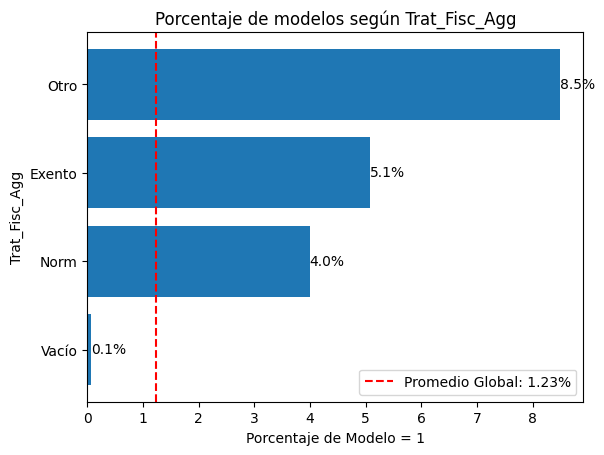

In [112]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].copy()
vendedores_1 = vendedores.copy()

porcentaje_modelo_1 = modelo_1.fillna('Vacío')['Trat_Fisc_Agg'].value_counts() / vendedores_1.fillna('Vacío')['Trat_Fisc_Agg'].value_counts() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('Trat_Fisc_Agg')
plt.title('Porcentaje de modelos según Trat_Fisc_Agg')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()

### `Trat_Fisc` y `Modelo`

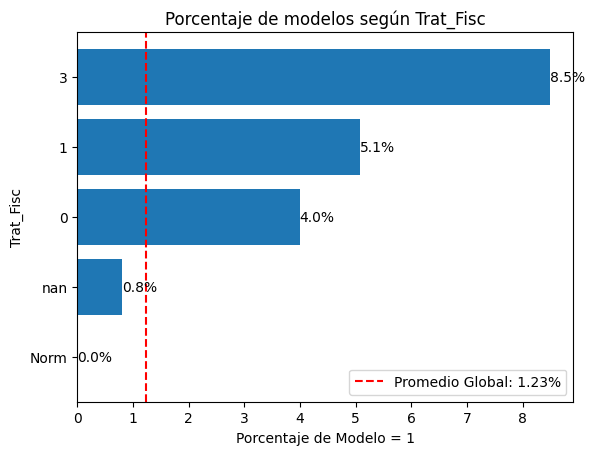

In [117]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].copy()
vendedores_1 = vendedores.copy()

porcentaje_modelo_1 = modelo_1.fillna('Vacío')['Trat_Fisc'].value_counts() / vendedores_1.fillna('Vacío')['Trat_Fisc'].value_counts() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('Trat_Fisc')
plt.title('Porcentaje de modelos según Trat_Fisc')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()

Qué pasa con las demás categorías? No tienen modelo? Estaría bueno q las muestre con 0 aunq sea

### `Trat_Dif` y `Modelo`

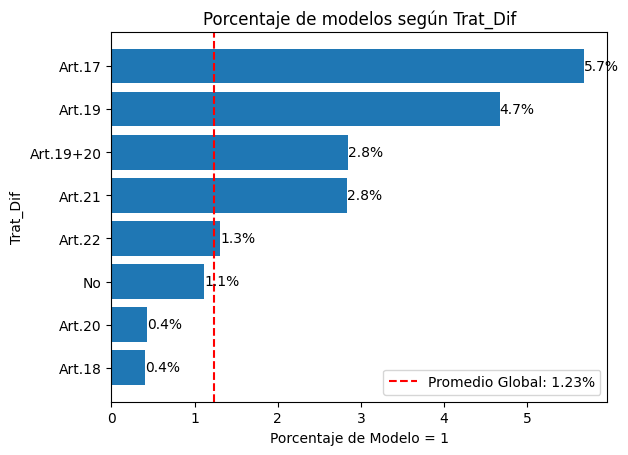

In [114]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].copy()
vendedores_1 = vendedores.copy()

porcentaje_modelo_1 = modelo_1.fillna('Vacío')['Trat_Dif'].value_counts() / vendedores_1.fillna('Vacío')['Trat_Dif'].value_counts() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('Trat_Dif')
plt.title('Porcentaje de modelos según Trat_Dif')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()

### `CM` y `Modelo`

In [119]:
# Verificar si existen diferentes valores de CM para un mismo ID
conteo_CM = vendedores.groupby('ID')['CM'].nunique().copy()

# Filtrar los IDs con diferentes valores de CM
ids_con_diferentes_CM = conteo_CM[conteo_CM > 1]

if ids_con_diferentes_CM.empty:
    print("Para cada ID solo existe un valor de CM.")
else:
    print("Para algunos IDs se asignan diferentes valores de CM:")
    print(ids_con_diferentes_CM.sort_values(ascending=False))

Para cada ID solo existe un valor de CM.


In [120]:
casos_unicos_cm_1 = vendedores[vendedores['CM'] == 1]['ID'].nunique()
print("Número de casos únicos de ID para CM = 1:", casos_unicos_cm_1)

Número de casos únicos de ID para CM = 1: 1


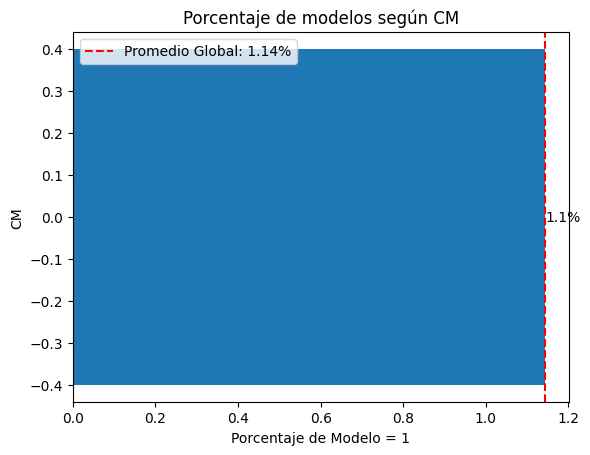

In [124]:
modelo_1 = vendedores[vendedores['Modelo'] == 1].drop_duplicates(subset=['ID']).copy()
vendedores_1 = vendedores.drop_duplicates(subset='ID').copy()

porcentaje_modelo_1 = modelo_1.fillna('Vacío').groupby('CM')['Modelo'].count() / vendedores_1.fillna('Vacío').groupby('CM')['Modelo'].count() * 100

# Ordenar los porcentajes de mayor a menor
porcentaje_modelo_1_sorted = porcentaje_modelo_1.sort_values(ascending=True)

plt.barh(porcentaje_modelo_1_sorted.index, porcentaje_modelo_1_sorted.values)
plt.xlabel('Porcentaje de Modelo = 1')
plt.ylabel('CM')
plt.title('Porcentaje de modelos según CM')

promedio_global = vendedores_1[vendedores_1['Modelo'] == 1].shape[0] / vendedores_1.shape[0] * 100
plt.axvline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.2f}%')
plt.legend()

for i, value in enumerate(porcentaje_modelo_1_sorted.values):
    plt.annotate(f'{value:.1f}%', (value, porcentaje_modelo_1_sorted.index[i]), ha='left', va='center')

plt.show()